In [ ]:
# --- NOTES ---
# CNN: https://colab.research.google.com/github/AviatorMoser/keras-mnist-tutorial/blob/master/MNIST%20in%20Keras.ipynb
# Vision transformer: https://towardsdatascience.com/a-demonstration-of-using-vision-transformers-in-pytorch-mnist-handwritten-digit-recognition-407eafbc15b0
# V1
# Run CNN and vision transformer package on MNIST dataset
# V2
# Write own implementation of ViT

In [ ]:
# --- IMPORTS ---
import numpy as np
import matplotlib.pyplot as plt
import cv2
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Activation, Dropout
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [ ]:
# --- IMPORT DATASET ---
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# Cast data to float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# Add color channel info
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (60000, 28, 28, 1)
y_train shape (60000,)
X_test shape (10000, 28, 28, 1)
y_test shape (10000,)


Text(0.5, 1.0, 'Class 8')

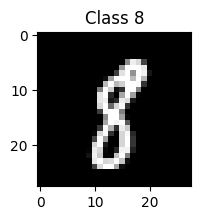

In [ ]:
# --- PREVIEW DATA ---
img_index = 300
plt.figure(figsize=(2, 2))
plt.imshow(X_train[img_index], cmap='gray', interpolation='none')
plt.title("Class {}".format(y_train[img_index]))

In [ ]:
# --- PREPROCESS DATA ---
# Make pixel intensities a standard normal distribution
# Calculate global mean and standard dev across all color channels
X_all = np.concatenate((X_train, X_test), axis=0)
global_mean = np.mean(X_all)
global_sigma = np.std(X_all)
X_train = (X_train - global_mean)/global_sigma
X_test = (X_test - global_mean)/global_sigma
print(f"X_train mew, sigma: {np.mean(X_train)}, {np.std(X_train)}")
print(f"X_test mew, sigma: {np.mean(X_test)}, {np.std(X_test)}")

# Turn labels into one hot encodings
n_classes = 10
y_train_hot = np_utils.to_categorical(y_train, n_classes)
y_test_hot = np_utils.to_categorical(y_test, n_classes)

X_train mew, sigma: -0.0008586799376644194, 0.9988964796066284
X_test mew, sigma: 0.005152455531060696, 1.006587028503418


# Convolutional Model

In [ ]:
# --- BUILD CNN MODEL ---
cnn_model = Sequential()

# Convolution Layer 1
cnn_model.add(Conv2D(32, (3, 3), input_shape=(28, 28, 1)))
cnn_model.add(BatchNormalization(axis=-1))
cnn_model.add(Activation('relu'))

# Convolution Layer 2
cnn_model.add(Conv2D(32, (3, 3)))
cnn_model.add(BatchNormalization(axis=-1))
cnn_model.add(Activation("relu"))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolution Layer 3
cnn_model.add(Conv2D(64, (3, 3)))
cnn_model.add(BatchNormalization(axis=-1))
cnn_model.add(Activation('relu'))

# Convolution Layer 4
cnn_model.add(Conv2D(64, (3, 3)))
cnn_model.add(BatchNormalization(axis=-1))
cnn_model.add(Activation("relu"))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Flatten())

# Dense Layer 5
cnn_model.add(Dense(512))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))

# Dense Layer 6
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(n_classes))
cnn_model.add(Activation('softmax'))

# Print model summary
cnn_model.summary()

# Compile model
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 26, 26, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 24, 24, 32)        0

In [ ]:
# --- DATA AUGMENTATION ---
# Create image generator objects
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)

test_gen = ImageDataGenerator()

# Feed data with batch loaders
train_generator = gen.flow(X_train, y_train_hot, batch_size=128)
test_generator = test_gen.flow(X_test, y_test_hot, batch_size=128)

In [ ]:
# --- TRAIN MODEL ---
cnn_model.fit(train_generator, steps_per_epoch=60000//128, epochs=5, verbose=1,
                    validation_data=test_generator, validation_steps=10000//128)

Epoch 1/5
468/468 [==============================] - 37s 51ms/step - loss: 0.1267 - accuracy: 0.9607 - val_loss: 0.0692 - val_accuracy: 0.9781
Epoch 2/5
468/468 [==============================] - 20s 42ms/step - loss: 0.0510 - accuracy: 0.9837 - val_loss: 0.0393 - val_accuracy: 0.9865
Epoch 3/5
468/468 [==============================] - 22s 47ms/step - loss: 0.0381 - accuracy: 0.9884 - val_loss: 0.0264 - val_accuracy: 0.9912
Epoch 4/5
468/468 [==============================] - 23s 48ms/step - loss: 0.0347 - accuracy: 0.9890 - val_loss: 0.0293 - val_accuracy: 0.9910
Epoch 5/5
468/468 [==============================] - 21s 45ms/step - loss: 0.0322 - accuracy: 0.9900 - val_loss: 0.0270 - val_accuracy: 0.9912


In [ ]:
# --- PERFORMANCE METRICS ---
score = cnn_model.evaluate(X_test, y_test_hot)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 4ms/step - loss: 0.0270 - accuracy: 0.9912
Test score: 0.026971956714987755
Test accuracy: 0.9911999702453613


313/313 [==============================] - 1s 2ms/step


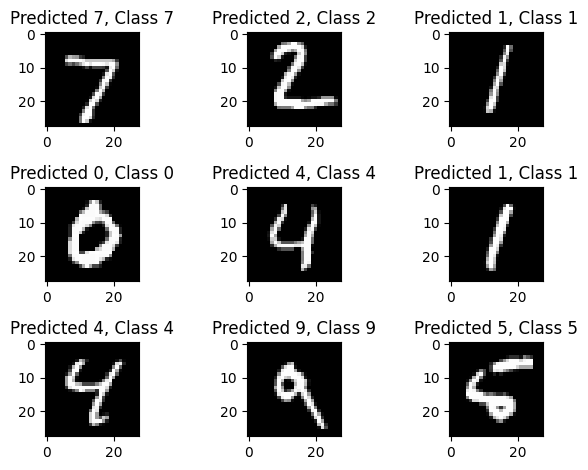

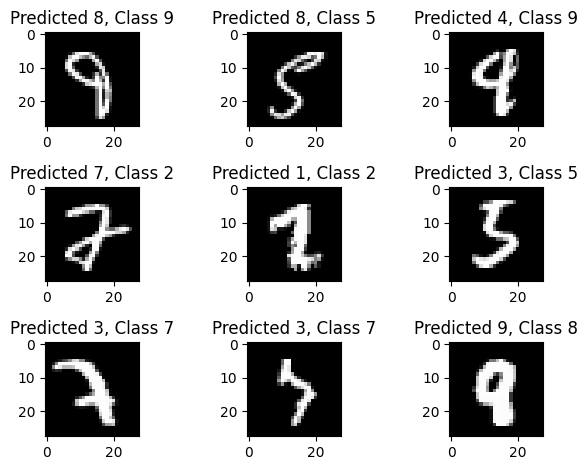

In [ ]:
# --- PREDICTION VISUALIZATION ---
# Make predictions
predict_x = cnn_model.predict(X_test)

# Interpret the output layer
predicted_classes = np.argmax(predict_x,axis=1)

# Check results against labels
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

# Visualize correct predictions
plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], np.argmax(y_test_hot[correct])))

plt.tight_layout()

# Visualize incorrect predictions
plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], np.argmax(y_test_hot[incorrect])))

plt.tight_layout()

# Vision Transformer Model

In [ ]:
# --- NOTES ---
# https://github.com/lucidrains/vit-pytorch#vision-transformer---pytorch
# https://peterbloem.nl/blog/transformers
# https://github.com/taki0112/vit-tensorflow#usage
# https://pypi.org/project/vit-keras/
# https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/image_classification_with_vision_transformer.ipynb#scrollTo=t395H7ple-3-

In [ ]:
# --- IMPORTS ---
!pip install tensorflow_addons
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# --- PATCHES CLASS ---
# Given a batch of images represented as a 4D tensor, returns a row of flattened
# patches for each image in the batch

class Patches(layers.Layer):
  def __init__(self, patch_size):
    super().__init__()
    # Length of one edge of square patch
    self.patch_size = patch_size

  def call(self, images):
    # Amount of images in batch
    # Images should be 4D tensor of shape (# img in batch, img width, img height, # channels)
    batch_size = tf.shape(images)[0]
    # A 4D tensor indexed by batch, row, column, flattened patch. The patch is
    # flattened spatially and across color channels
    patches = tf.image.extract_patches(
      images=images,
      sizes=[1, self.patch_size, self.patch_size, 1],
      strides=[1, self.patch_size, self.patch_size, 1],
      rates=[1, 1, 1, 1],
      padding="VALID",
    )
    # Length of flattened patch
    patch_len = patches.shape[-1]
    # Collapse unspecified axes into one axis, essentially creating a row of
    # flattened patches as each member of the batch
    patches = tf.reshape(patches, [batch_size, -1, patch_len])
    return patches

In [ ]:
# --- PATCH ENCODER CLASS ---
# Passes a patch through a dense layer with a learnable position embedding

class PatchEncoder(layers.Layer):
  def __init__(self, num_patches, projection_dim):
    super().__init__()
    self.num_patches = num_patches
    # Projects each flattened patch into vector using a dense layer
    # 3D tensor of shape (# img in batch, # patches, projection_dim)
    self.projection = layers.Dense(units=projection_dim)
    # Creates an embedding vector for each position/patch index
    # Results in a 2D embedding table, where each element is a learnable weight
    # 2D tensor of shape (# patches, projection_dim)
    self.position_embedding = layers.Embedding(
      input_dim=num_patches, output_dim=projection_dim
    )

  def call(self, patches):
    positions = tf.range(start=0, limit=self.num_patches, delta=1)
    # Broadcasting of the position_embedding tensor results in the same shape
    # as the projection tensor
    # The same position embedding table is applied to each image
    encoded = self.projection(patches) + self.position_embedding(positions)
    return encoded

In [ ]:
# --- CREATE MULTILAYER PERCEPTION ---
# Multilayer DNN with GELU activation and dropout normalization
def mlp(x, hidden_units, dropout_rate):
  for units in hidden_units:
    x = layers.Dense(units, activation=tf.nn.gelu)(x)
    x = layers.Dropout(dropout_rate)(x)
  return x

In [ ]:
# --- CREATE ViT MODEL ---
# https://arxiv.org/abs/1706.03762

def ViT(input_shape, patch_size, num_classes, projection_dim=64, transformer_layers=8, num_heads=4, mlp_head_units=[2048, 1024]):
  num_patches = (input_shape[0] // patch_size) ** 2
  # Defines size of MLP
  transformer_units = [projection_dim * 2, projection_dim]

  # Create Keras tensor object based on input parameters
  inputs = layers.Input(shape=input_shape)

  # Create patches from inputs
  # Each input produces a 2D matrix of flattened patches
  patches = Patches(patch_size)(inputs)

  # Create patch encodings
  # Creates a 2D tensor where each row is a patch projected as a vector
  # A 2D position embedding matrix is added/superimposed on the patch projections
  # 2D tensor is broadcasted into 3D batch tensor
  # Shape is [batch_size, projection_dim]
  encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

  # Create multiple layers of the transformer block
  # Transformer blocks are not changing dimensionality of tensors
  for _ in range(transformer_layers):
    # Normalization layer
    x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    # Multi-head attention layer with self attention
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
    # Add layer outputs
    x2 = layers.Add()([attention_output, encoded_patches])
    # Normalization layer
    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
    # MLP
    x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
    # Add layer outputs and reset output as input to next transformer block
    encoded_patches = layers.Add()([x3, x2])

  # ---
  # Mark: [batch,  n_patches,  H]

  # Create a [batch_size, projection_dim] tensor.
  representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
  representation = layers.Flatten()(representation)
  representation = layers.Dropout(0.5)(representation)
  # Add MLP.
  features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
  # Classify outputs.
  logits = layers.Dense(num_classes)(features)
  # Create the Keras model.
  model = keras.Model(inputs=inputs, outputs=logits)

  # ---
  # Output should be the exact same shape as the input image

  return model

In [ ]:
# --- INITIALIZE VIT CLASSIFIER ---
# Hyperparameters
patch_size = 7
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 10
input_shape = X_train.shape[1:]

vit = ViT(input_shape, patch_size, n_classes)
# vit_model.summary()

In [ ]:
# --- DEFINE EXPERIMENT PARAMETERS AND TRAIN MODEL ---
def run_experiment(model):
  optimizer = tfa.optimizers.AdamW(
    learning_rate=learning_rate, weight_decay=weight_decay
  )

  model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
      keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
      keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
  )

  checkpoint_filepath = "/tmp/checkpoint"
  checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
  )

  history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.1,
    callbacks=[checkpoint_callback],
  )

  model.load_weights(checkpoint_filepath)
  _, accuracy, top_5_accuracy = model.evaluate(X_test, y_test)
  print(f"Test accuracy: {round(accuracy * 100, 2)}%")
  print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

  return history

history = run_experiment(vit)

Epoch 1/10
211/211 [==============================] - 36s 90ms/step - loss: 0.4543 - accuracy: 0.8571 - top-5-accuracy: 0.9840 - val_loss: 0.1017 - val_accuracy: 0.9713 - val_top-5-accuracy: 0.9985
Epoch 2/10
211/211 [==============================] - 12s 56ms/step - loss: 0.1772 - accuracy: 0.9460 - top-5-accuracy: 0.9983 - val_loss: 0.0674 - val_accuracy: 0.9802 - val_top-5-accuracy: 0.9992
Epoch 3/10
211/211 [==============================] - 12s 55ms/step - loss: 0.1253 - accuracy: 0.9614 - top-5-accuracy: 0.9991 - val_loss: 0.0571 - val_accuracy: 0.9833 - val_top-5-accuracy: 0.9990
Epoch 4/10
211/211 [==============================] - 11s 52ms/step - loss: 0.1049 - accuracy: 0.9676 - top-5-accuracy: 0.9994 - val_loss: 0.0582 - val_accuracy: 0.9828 - val_top-5-accuracy: 0.9990
Epoch 5/10
211/211 [==============================] - 12s 55ms/step - loss: 0.0884 - accuracy: 0.9728 - top-5-accuracy: 0.9996 - val_loss: 0.0430 - val_accuracy: 0.9885 - val_top-5-accuracy: 0.9993
Epoch 6/10

Resized image shape: (1, 28, 28, 1)
Patches shape: (1, 16, 49)
Image size: 28 X 28
Patch size: 7 X 7
Patches per image: 16
Elements per patch: 49


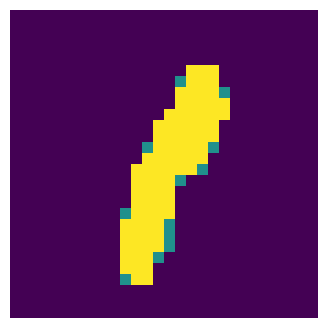

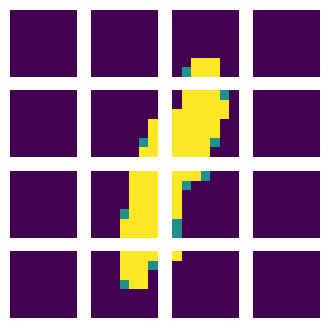

In [ ]:
# --- VISUALIZE PATCHES ---
image_size = 28
patch_size = 7

plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
print(f"Resized image shape: {resized_image.shape}")
patches = Patches(patch_size)(resized_image)
print(f"Patches shape: {patches.shape}")
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 1))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")